# Materials associated with the paper: 

Cao, W., Williams, S., Flament, N., Zahirovic, S., Scotese, C., and Müller, R. D., 2018. Paleolatitudinal distribution of lithologic indicators of climate in a paleogeographic framework. Geological Magazine, 1-24. doi:10.1017/S0016756818000110.

### This Jupyter notebook is used to generate Figures 4-8 for the paper.

The code in the notebook is written in Python 2.7. It utilises the standard scientific Python modules including numpy, pandas, mpl_toolkits, matplotlib, os, and the open source module 'pygplates' which provides a Python API to the GPlates software (https://www.gplates.org/).


## Import Python modules

In [2]:
from mpl_toolkits.basemap import Basemap
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import pandas as pd    
from matplotlib import colors
from matplotlib import legend
import pygplates
from matplotlib.patches import Polygon
import glob, os
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
#%matplotlib inline

## Figure 5a

### Read the data and models

In [3]:
# input the lithologic data - PresentDay_LithData_Matthews2016_CEG_410-0Ma_ToAgeCorrected_CookCut_DeleteDataUsingStartAge
point_feature_filename_coals = '../Data/Lithologic_Data/PresentDay_LithData_Matthews2016_CEG_410-0Ma_ToAgeCorrected_CookCut_DeleteDataUsingStartAge.shp'
input_feature_collection_coals = pygplates.FeatureCollection(point_feature_filename_coals)

# read the rotation file
input_rotation_filename_Matthews2016PMAG_fixed = ['../Data/Tectonic_model/Global_EB_410-0Ma_GK07_Matthews_etal_PMAG_fixed_crossovers.rot']
rotation_model = pygplates.RotationModel(input_rotation_filename_Matthews2016PMAG_fixed)

# read contient polygons file
continental_polygons = pygplates.FeatureCollection('../Data/Tectonic_model/ContPolys/PresentDay_ContinentalPolygons_Matthews++.shp')


### Set the ages for the data points

In [4]:
# the ages of the data points
age_range_list = [(419,393),   # Early Devonian
           (393,388),   # Middle Devonian (Eifelian)
           (388,383),   # Middle Devonian (Givetian)
           (383,359),   # Late Devonian
           (359,331),   # Early Carboniferous (Tournaisian-Visean)
           (331,323),   # Early Carboniferous (Serpukhovian)
           (323,307),   # Late Carboniferous (Bashkirian-Moscovian)
           (307,299),   # Late Carboniferous (Kasimovian-Gzhelian)
           (299,290),   # Early Permian (Asselian-Sakmarian)
           (290,252),   # Middle-Late Permian (Artinskian-Lopingian)
           (252,247),   # Early Triassic
           (247,237),   # Middle Triassic
           (237,201),   # Late Triassic
           (201,164),   # Early and Middle Jurassic
           (164,145),   # Late Jurassic
           (145,113),   # Early Cretaceous (Berriasian-Aptian)
           (113,89.8),   # Late Cretaceous (Albian-Turonian)
           (89.8,66.0),   # Late Cretaceous (Coniacian-Maastrichtian)
           (66.0,56.0),   # Paleocene
           (56.0,47.8),  # Early Eocene (Ypresian?)
           (47.8,33.9),  # Middle and Late Eocene
           (33.9,23.0),  # Oligocene
           (23.0,5.3),    # Miocene
           (0.01,-0.01)]

i = 0
for i in np.arange(0,24,1):
    Age = np.mean(age_range_list[i])
    print Age

406.0
390.5
385.5
371.0
345.0
327.0
315.0
303.0
294.5
271.0
249.5
242.0
219.0
182.5
154.5
129.0
101.4
77.9
61.0
51.9
40.85
28.45
14.15
0.0


### Define a function for reconstructing the data points back in time

In [5]:
# define a function for reconstructing the data points back in time
def get_paleolithology(point_features,rotation_model):
    pX = []
    pY = []
    pAge = []
    LithCode=[]
    reconstructed_points = []
    for point in input_feature_collection_coals:
        lithcode = point.get_shapefile_attribute('LithCode')
        #if lithcode == 'C' and point.get_reconstruction_plate_id()!=0:
        #if lithcode == 'E' and point.get_reconstruction_plate_id()!=0:
        #if lithcode== 'T' or lithcode=='D' or lithcode=='G' and point.get_reconstruction_plate_id()!=0:
        BirthTime = np.median(point.get_valid_time())
        if BirthTime<410:
            pAge.append(BirthTime)
            point_rotation = rotation_model.get_rotation(BirthTime, point.get_reconstruction_plate_id(), anchor_plate_id=0) #obtain rotating rules
            reconstructed_point = point_rotation * point.get_geometry() # carry out reconstruction
            pX.append(reconstructed_point.to_lat_lon()[1])
            pY.append(reconstructed_point.to_lat_lon()[0])
            reconstructed_points.append(point)
            LithCode.append(point.get_shapefile_attribute('LithCode'))
    return pX,pY,pAge,LithCode

# reconstruct all data and get their x, y coordinates and ages
pX,pY,pAge,LithCode = get_paleolithology(input_feature_collection_coals,rotation_model)
data_xy = []
data_xy = zip(LithCode,pY,pX,pAge)
#print data_xy

### Remove the sampling bias

In [6]:
# remove the sampling bias
result_original = []
result_SamplingBiasRemoved = []
result_flipped = []
result_doubled = []

for i in np.arange(0,24,1):
    
    result = []
    result_0 = []
    result_1 = []
    result_2 = []
    result_3 = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #180, longtitude
    yedges = np.arange(-90, 91, 5) #90, latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    result_0 = np.nansum(data_hist[0], axis=0)
    result_original.append(result_0)
    #print type(result_original)
    
    # remove the sampling bias
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    #print result_1
    result_SamplingBiasRemoved.append(result_1)
        
    # flip the data
    result_2 = np.flipud(result_1[:18])+result_1[18:]
    result_flipped.append(result_2) # add data on south hemisphere to north hemishpere
    #print result_flipped
    
    # double the data
    result_3 = list(np.flipud(result_2)) + list(result_2) 
    result_doubled.append(np.array(result_3)) # add data on south hemisphere to north hemishpere
    #print result_doubled


/Users/wenchaocao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide


### Make the figure

/Users/wenchaocao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


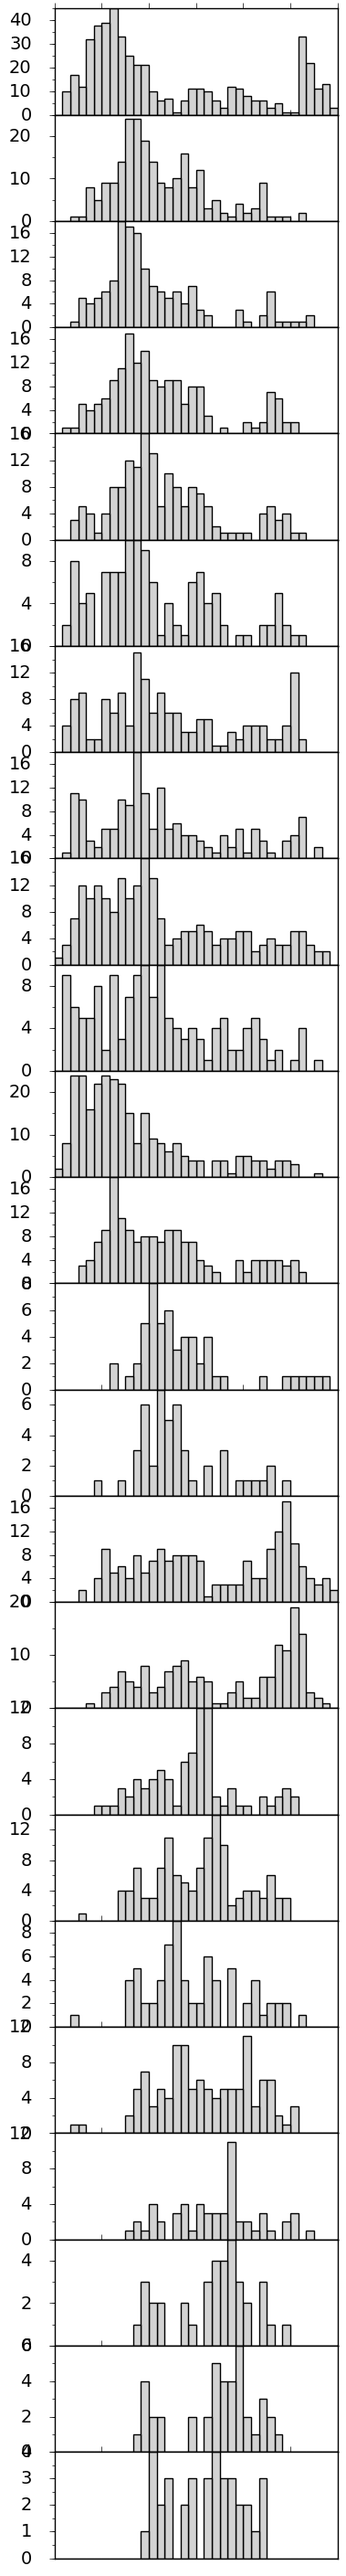

In [7]:

fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))  #figsize=(4, 36) #figsize=(0.74, 6.65)
#fig, axes = plt.subplots(figsize=(8, 6)) 

for i in np.arange(0,24,1):
    
    result = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    
    # plot original data
    result_0 = np.nansum(data_hist[0], axis=0)
    #axes[23-i].bar(np.array(yedges[:-1]), result_0, width=5, color='lightgrey') #,alpha=0.4
    
    # plot data sampling bias corrected
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    axes[23-i].bar(np.array(yedges[:-1]), result_1, width=5, color='lightgrey') #,alpha=0.4
    
    '''
    # flipped data
    result_2 = np.flipud(result_1[:18])+result_1[18:]
    
    # double the data
    result_3 = list(np.flipud(result_2)) + list(result_2)
    #axes[23-i].bar(np.array(yedges[:-1]), result_3, width=2, color='blue',alpha=0.4)
    '''
    
    axes[23-i].set_xticks(np.arange(-90, 91, 30))
    axes[23-i].set_xticklabels([])
    axes[23-i].set_xlim((90,-90))
    axes[23-i].set_ylim(ymin=0)
    #axes[23-i].set_ylim((0,0.01))
    axes[23-i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50
    axes[23-i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[23-i].xaxis.set_ticks_position('top') # bottom
    axes[23-i].set_yticks(axes[23-i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[23-i].get_yticks())[0]
    axes[23-i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[23-i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[23-i].yaxis.set_ticks_position('left')
    

fig.subplots_adjust(hspace=0.00)
plt.savefig('Output/Fig_05a.pdf',dpi=600) #SamplingBiasRemoved
plt.show()


## Figure 5d

### Read the data and make the figure

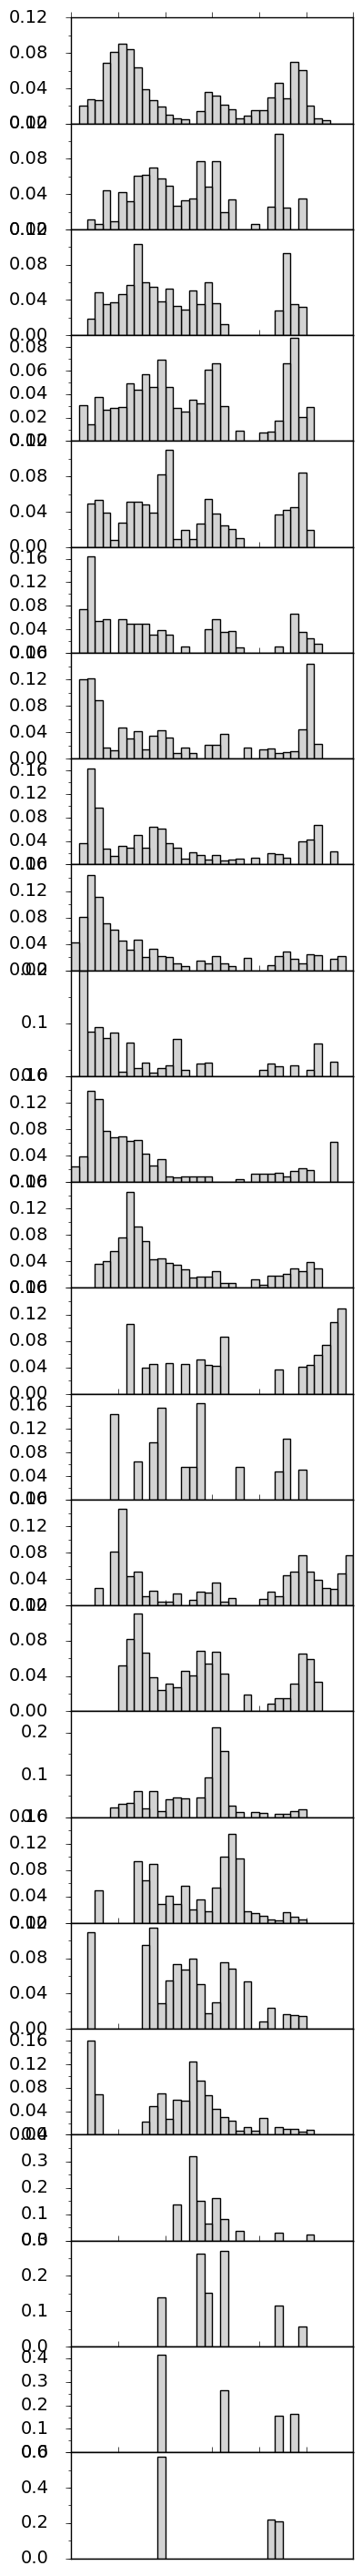

In [8]:
# Read coals data 
data_raw_Matthews2016 = pd.read_excel('../Data/Lithologic_Data/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_BinningSize5_Normarlised.xlsx')
data = np.array(data_raw_Matthews2016)

fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))

for i in np.arange(0,24,1):
    
    result = []
    
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size    
    
    # Coals, evaporites and glacial deposits
    axes[23-i].bar(np.array(yedges[:-1]), data[:,i]/sum(np.float64(data[:,i])), width=5, color='lightgrey') #edgecolor='grey',
    
    axes[23-i].set_xticks(np.arange(-90, 91, 30))
    axes[23-i].set_xticklabels([])
    axes[23-i].set_xlim((90,-90))
    axes[23-i].set_ylim(ymin=0)
    #axes[23-i].set_ylim((0,0.01))
    axes[23-i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50
    axes[23-i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[23-i].xaxis.set_ticks_position('top') # bottom
    axes[23-i].set_yticks(axes[23-i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[23-i].get_yticks())[0]
    axes[23-i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[23-i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[23-i].yaxis.set_ticks_position('left')
    

fig.subplots_adjust(hspace=0.00)
plt.savefig('Output/Fig_05d.pdf',dpi=600)
plt.show()


## Figure 5f

### Read the data and make the figure

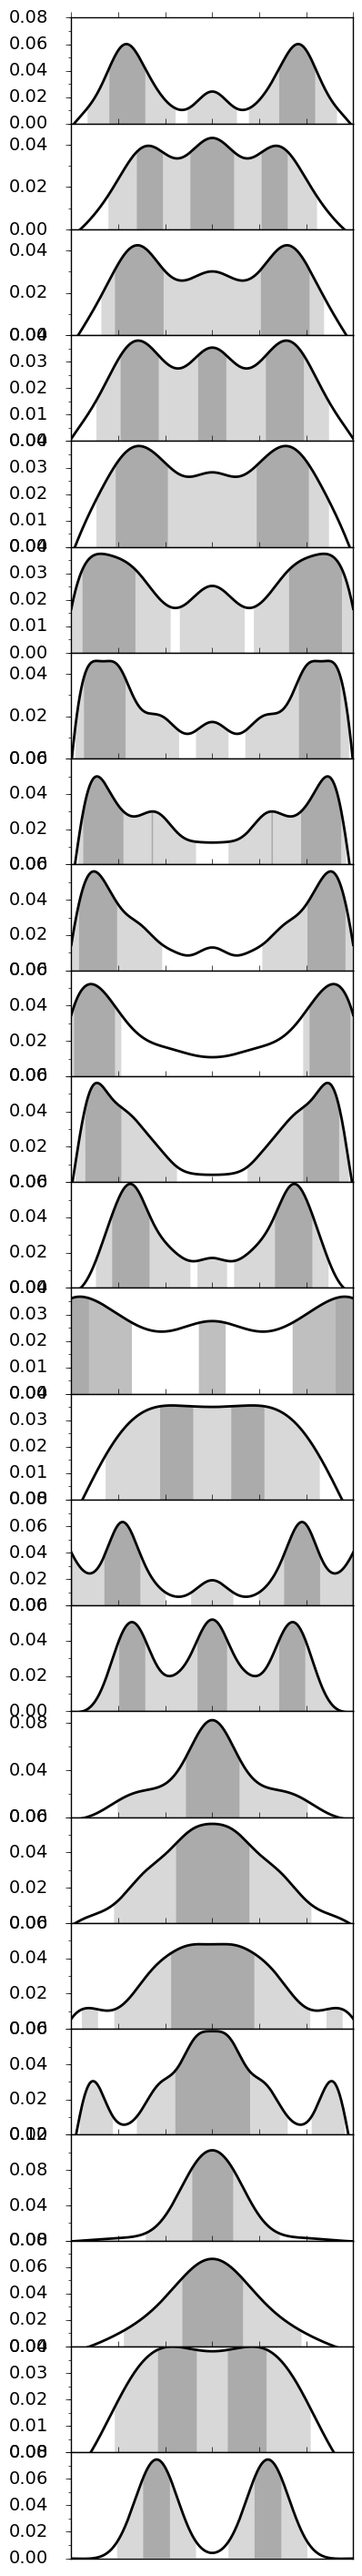

In [9]:
fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))

for i in np.arange(0,24,1):
    yedges = np.arange(-90, 91, 5) #latitude
    
    ##############################################
    # Matthews2016
    # Coals
    data_coal_sizer_Matthews2016 = pd.read_table('../Data/SiZer/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Data_XY_BestFitting_'+str(i)+'.txt',header=None, delimiter=r"\s+")
    #axes[23-i].fill_between(data_coal_sizer_Matthews2016.iloc[:,0],0,data_coal_sizer_Matthews2016.iloc[:,1]/np.sum(data_coal_sizer_Matthews2016.iloc[:,1]),facecolor='lightgrey', interpolate=False) #,linewidth=2.0 , alpha=0.3
    axes[23-i].plot(data_coal_sizer_Matthews2016.iloc[:,0],data_coal_sizer_Matthews2016.iloc[:,1],color='black',linewidth=2.0) #,
    
    ##############################################
    # HDR of coals
    data_raw_hdr = pd.read_csv('../Data/HDR/9_3_Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped_Doubled_BinningSize5_Normalised/hdr_'+str(i)+'.csv')
    data_hdr = np.array(data_raw_hdr)
    boundary_50CI_1 = data_hdr[2,1]
    boundary_95CI_1 = data_hdr[0,1]

    y_50 = np.interp(boundary_50CI_1, data_coal_sizer_Matthews2016.iloc[:,0], data_coal_sizer_Matthews2016.iloc[:,1])
    y_95 = np.interp(boundary_95CI_1, data_coal_sizer_Matthews2016.iloc[:,0], data_coal_sizer_Matthews2016.iloc[:,1])
    
    axes[23-i].fill_between(data_coal_sizer_Matthews2016.iloc[:,0],data_coal_sizer_Matthews2016.iloc[:,1],where=data_coal_sizer_Matthews2016.iloc[:,1] > y_95,color='grey',alpha=0.3,linewidth=0) # ,edgecolor='grey'
    #axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_75,color='grey',alpha=0.4) #linewidth=2.0,
    axes[23-i].fill_between(data_coal_sizer_Matthews2016.iloc[:,0],data_coal_sizer_Matthews2016.iloc[:,1],where=data_coal_sizer_Matthews2016.iloc[:,1] > y_50,color='grey',alpha=0.5,linewidth=0) #linewidth=.0,
    
    ##############################################    
    # Evaporites
    #data_sizer_Matthews2016 = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/9_3_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Evaporites_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Data_XY_BestFitting_'+str(i)+'.txt',header=None, delimiter=r"\s+")
    ##axes[23-i].fill_between(data_coal_sizer_Matthews2016.iloc[:,0],0,data_coal_sizer_Matthews2016.iloc[:,1]/np.sum(data_coal_sizer_Matthews2016.iloc[:,1]),facecolor='lightgrey', interpolate=False) #,linewidth=2.0 , alpha=0.3
    #axes[23-i].plot(data_sizer_Matthews2016.iloc[:,0],data_sizer_Matthews2016.iloc[:,1],color='black',linewidth=2.0) #,

    #######################
    # HDR of evaporites
    #data_raw_hdr = pd.read_csv('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/HDR/Evaporites_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped_Doubled_BinningSize5_Normalised/hdr_'+str(i)+'.csv')
    #data_hdr = np.array(data_raw_hdr)
    #boundary_50CI_1 = data_hdr[2,1]
    #boundary_95CI_1 = data_hdr[0,1]

    #y_50 = np.interp(boundary_50CI_1, data_sizer_Matthews2016.iloc[:,0], data_sizer_Matthews2016.iloc[:,1])
    #y_95 = np.interp(boundary_95CI_1, data_sizer_Matthews2016.iloc[:,0], data_sizer_Matthews2016.iloc[:,1])
    
    #axes[23-i].fill_between(data_sizer_Matthews2016.iloc[:,0],data_sizer_Matthews2016.iloc[:,1],where=data_sizer_Matthews2016.iloc[:,1] > y_95,color='grey',alpha=0.3,linewidth=0) # ,edgecolor='grey'
    ##axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_75,color='grey',alpha=0.4) #linewidth=2.0,
    #axes[23-i].fill_between(data_sizer_Matthews2016.iloc[:,0],data_sizer_Matthews2016.iloc[:,1],where=data_sizer_Matthews2016.iloc[:,1] > y_50,color='grey',alpha=0.5,linewidth=0) #linewidth=.0,


    ##############################################
    axes[23-i].set_xticks(np.arange(-90, 91, 30))
    axes[23-i].set_xticklabels([])
    axes[23-i].set_xlim((90,-90))
    axes[23-i].set_ylim(ymin=0)
    #axes[23-i].set_ylim((0,0.01))
    axes[23-i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50
    axes[23-i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[23-i].xaxis.set_ticks_position('top') # bottom
    axes[23-i].set_yticks(axes[23-i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[23-i].get_yticks())[0]
    axes[23-i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[23-i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[23-i].yaxis.set_ticks_position('left')
    
fig.subplots_adjust(hspace=0.00)
plt.savefig('Output/Fig_05f.pdf')
plt.show()

## Figure 8

### Read the data of land areas

In [10]:
# read the data of land areas 
data_Matthews2016 = pd.read_excel('../Data/LandArea_Total/3_1_TotalLandArea_onTwoHemispheres_Matthews2016Modified_EachMap.xlsx')
data_Scotese2008 = pd.read_excel('../Data/LandArea_Total/3_2_TotalLandArea_onTwoHemispheres_Scotese2008_EachMap.xlsx')
data_Golonka2009 = pd.read_excel('../Data/LandArea_Total/TotalLandArea_Golonka_BinningSize5.xlsx', sheetname='Sheet2')

print data_Matthews2016.iloc[:,0]
#print data_Matthews2016.iloc[:,7] # north hemi
#print data_Matthews2016.iloc[:,8] # south hemi

0       0.00
1      14.15
2      28.45
3      40.85
4      51.90
5      61.00
6      77.90
7     101.40
8     129.00
9     154.50
10    182.50
11    219.00
12    242.00
13    249.50
14    271.00
15    294.50
16    303.00
17    315.00
18    327.00
19    345.00
20    371.00
21    385.50
22    390.50
23    406.00
Name: Time, dtype: float64


### Make the figure

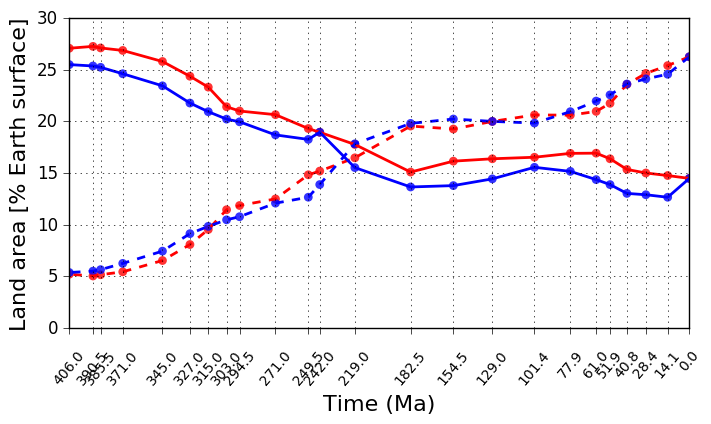

In [11]:
fig, ax = plt.subplots(figsize=(8,4)) #figsize=(12,8)

#print data[0:1]
plt.plot(data_Matthews2016.iloc[:,0], 100*data_Matthews2016.iloc[:,7],'r--',linewidth=2.0)
plt.plot(data_Matthews2016.iloc[:,0], 100*data_Matthews2016.iloc[:,8],'r-',linewidth=2.0)
plt.scatter(data_Matthews2016.iloc[:,0], 100*data_Matthews2016.iloc[:,7], c='red',alpha=0.8, edgecolors='none',s=40)
plt.scatter(data_Matthews2016.iloc[:,0], 100*data_Matthews2016.iloc[:,8], c='red',alpha=0.8, edgecolors='none',s=40)

# Scotese
plt.plot(data_Scotese2008.iloc[:,0], 100*data_Scotese2008.iloc[:,7],'b--',linewidth=2.0)
plt.plot(data_Scotese2008.iloc[:,0], 100*data_Scotese2008.iloc[:,8],'b-',linewidth=2.0)
plt.scatter(data_Scotese2008.iloc[:,0], 100*data_Scotese2008.iloc[:,7], c='b',alpha=0.8, edgecolors='none',s=40)
plt.scatter(data_Scotese2008.iloc[:,0], 100*data_Scotese2008.iloc[:,8], c='b',alpha=0.8, edgecolors='none',s=40)

#plt.legend(('North hemisphere (Mattthews et al., 2016)','South hemisphere (Mattthews et al., 2016)',
#           'North hemisphere (Scotese, 2008)','South hemisphere (Scotese, 2008)'),
#            bbox_to_anchor=(.97,0.30), loc=1, borderaxespad=0.,fontsize='small')
plt.xlabel('Time (Ma)', fontsize=16)
plt.xticks(data_Matthews2016.iloc[:,0], size=10, rotation=50) #, rotation=50
ax.xaxis.set_tick_params(labelsize=10,direction='out')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Land area [% Earth surface]', fontsize=16)
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_tick_params(labelsize=12,direction='out')
plt.xlim((406,0))
plt.ylim((0,30))
plt.grid()

plt.savefig('Output/Fig_08.pdf',dpi=600)
plt.show()
